In [159]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Patch
from matplotlib.pyplot import scatter
from matplotlib.lines import Line2D

# To add text and a border to the map
from PIL import Image, ImageOps, ImageColor, ImageFont, ImageDraw 

%matplotlib inline

In [4]:
ox.__version__

'0.16.1'

In [2]:
# using this color palette: https://colorhunt.co/palette/161876

In [24]:
def _color(color, mode):
    color = ImageColor.getcolor(color, mode)
    return color

# Expand image
def expand(image, fill = BACKGROUND, bottom = 50, left = None, right = None, top = None):
    """
    Expands image
    
    Parameters
    ----------
    
    image: The image to expand.
    bottom, left, right, top: Border width, in pixels.
    param fill: Pixel fill value (a color value).  Default is 0 (black).
    
    return: An image.
    """
    
    
    if left == None:
        left = 0
    if right == None:
        right = 0
    if top == None:
        top = 0
        
    width = left + image.size[0] + right
    height = top + image.size[1] + bottom - 100
    out = Image.new(image.mode, (width, height), _color(fill, image.mode))
    out.paste(image, (left, top))
    return out

# Add border
def add_border(input_image, output_image, fill=BACKGROUND, bottom = 50, left = None, right = None, top = None):
    """ Adds border to image and saves it.
    Parameters
    ----------
    
        
    input_image: str,
        String object for the image you want to load. This is the name of the file you want to read.
    
    output_image: str,
        String object for the output image name. This is the name of the file you want to export.
    
    fill: str,
        Hex code for border color. Default is set to reddish. 
        
    bottom, left, right, top: int,
        Integer object specifying the border with in pixels.
    
    """
    
    
    if left == None:
        left = 0
    if right == None:
        right = 0
    if top == None:
        top = 0
        
    img = Image.open(input_image)
    bimg = expand(img, bottom = bottom, left = left, right = right, top = top, fill= fill)
    bimg.save(output_image)
    return bimg

In [185]:
#color_map = {
#    'long_road': "#bbbbbb",
#    "medium_long_road": "#30bab0",
#    "medium_road": "#e78119",
#    "medium_short_road": "",
#    "short_road": "#d40a47",
#    "default": "w"
#}
BACKGROUND = "#211717"
CEMETERY = "#f58b54"
color_map = {
    'long_road': "#dfddc7",
    "medium_long_road": "#dfddc7",
    "medium_road": "#dfddc7",
    "medium_short_road": BACKGROUND,
    "short_road": BACKGROUND,
    "default": "#dfddc7"
}



thickness_map = [['footway', '']]

# bbox is same format as from:
# https://boundingbox.klokantech.com
# csv RAW format
def get_map(bbox):
    # Get data for places
    G = ox.graph_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], network_type = "drive", simplify = True)
    return G

def create_colors_and_widths(color_map, G):
    edge_data = []
    for u, v, k, data in G.edges(keys=True, data=True):
        edge_data.append(data)

    roadColors = []
    for item in edge_data:
        if "length" in item.keys():

            if item["length"] <= 100:
                color = color_map['short_road']

            elif item["length"] > 100 and item["length"] <= 200:
                color = color_map['medium_road']

            elif item["length"] > 200 and item["length"] <= 400:
                color = color_map['medium_long_road']

            elif item["length"] > 400 and item["length"] <= 800:
                color = color_map['long_road']

            else:
                color = color_map['default']
        roadColors.append(color)
        
    roadWidths = []
    # TODO: use thickness map
    for item in edge_data:
        if "footway" in item["highway"] or "living_street" in item['highway'] or 'tertiary_link' in item['highway'] or item['length'] < 100:
            linewidth = 0
        else:
            linewidth = 2.5

        roadWidths.append(linewidth)
    return (roadColors, roadWidths)

def get_cemeteries(bbox):
    import numpy as np
    cemeteries = ox.geometries_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], tags={'landuse': ['cemetery']})#, 'amenity': 'grave_yard'})
    cems = cemeteries[cemeteries.name != 'Cemetery']
    cems = cems[cems.name != np.nan]
    cemeteries = cems.dropna(axis=0, subset=['name'])
    
    cemeteries['area'] = cemeteries['geometry'].apply(lambda g: g.area)
    cemetery_min_area = cemeteries['area'].mean() - (cemeteries['area'].std()/2)
    
    return cemeteries[cemeteries['area'] > cemetery_min_area]

def plot_map(bbox):
    G = get_map(bbox)
    roadColors, roadWidths = create_colors_and_widths(color_map, G)
    cemeteries = get_cemeteries(bbox)
    
         # Make Map
    fig1, ax1 = ox.plot_graph(G, node_size=0,show=False,
                                        figsize=(40,40), dpi = 300, edge_color=roadColors,
                              bgcolor=BACKGROUND,
                              edge_linewidth=roadWidths, edge_alpha=1)
    fig1.set_facecolor(BACKGROUND)
    # plot cemeteries
    fig2, ax2 = ox.plot.plot_footprints(cemeteries, color=CEMETERY, show=False,
                                        dpi = 300,  ax=ax1,
                                        bgcolor = BACKGROUND, save = False)

   
    # plot cemetery labels (numbers)
    legend_elements = []
    
    # Text and marker size
    markersize = 16
    fontsize = 25
    
    cemetery_objs = []
    
    for n, data in enumerate(cemeteries[['name', 'geometry']].to_dict('records')):
        number_text = "{}".format(n)
        name_text = data['name']
#        c = data['geometry'].centroid
        b = data['geometry'].bounds
        c = [b[0], b[1]]
        
        cemetery_objs.append({'name': name_text, 'id': int(number_text), 'lat': b[0], 'lng': b[1]})
        
        print("Placing label {} for {} at {}, {}".format(number_text, name_text, c[0], c[1]))
        ax2.annotate(number_text,(c[0], c[1]), c=BACKGROUND, fontsize=25,
                     fontfamily='monospace',
             bbox={"boxstyle" : "circle", "color":"#dfddc7", "edgecolor":BACKGROUND})
        
        # add legend marker
        
        legend_element = Line2D([0], [0], marker='${}$'.format(number_text), 
                                facecolor="#dfddc7",
                                linestyle="None",
                                label="{}".format(name_text), markersize=30)
                               #facecolor='#dfddc7')
                               #markerfacecolor='#dfddc7')
        legend_elements.append(legend_element)


    l = ax2.legend(handles=legend_elements, bbox_to_anchor=(0, 0), loc='upper left', 
                   frameon=False, 
                   ncol=4,
                   framealpha = 1,
                  facecolor = BACKGROUND, fontsize = fontsize, prop={'family':"monospace", 'size':25})  

    # Legend font color
    for text in l.get_texts():
        text.set_color("#dfddc7")
        
    # Save figure
    fig2.set_frameon(True)
    fig1.savefig("bbox.png", dpi=300, bbox_inches='tight', format="png", facecolor=BACKGROUND, transparent=False)
    fig2.savefig("bbox_cemetery.png", dpi=300, bbox_inches='tight', format="png", facecolor=BACKGROUND, transparent=False)
    return fig2, ax2, cemetery_objs

def plot_map_and_legend(bbox):
    fig, ax, cemeteries = plot_map(bbox)
    BOTTOM_SIZE = 1600
    margin = 200
    img_with_border = add_border('bbox_cemetery.png', 'bbox_cemetery_border.png', fill=BACKGROUND, bottom=BOTTOM_SIZE)
    width = image.size[0]
    height = image.size[1]
    n_cemeteries = len(cemeteries)
    # 3 columns
    vspace = (BOTTOM_SIZE - margin)/n_cemeteries
    

In [183]:
bounding_box_MA = [-72.1222475215,41.9918629832,-70.4666108648,42.7367403211]
bounding_box_BOS_BIG = [-71.5068665922,42.2212032979,-70.9204662667,42.4887447671]
bounding_box_BOS = [-71.1929535654,42.2912856611,-70.9781663877,42.4024328423]

/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Placing label 0 for Winthrop Cemetery at -70.9830733, 42.3748496
Placing label 1 for Walter Street Burying Ground at -71.1303585, 42.2927415
Placing label 2 for Forest Hills Cemetery at -71.1146014, 42.2886428
Placing label 3 for Saint Marys Cemetery at -71.0819871, 42.2889412
Placing label 4 for Mount Benedict Cemetery at -71.1723007, 42.2933556
Placing label 5 for Eliot Cemetery at -71.0814916, 42.331601
Placing label 6 for Kings Chapel Burying Ground at -71.0601852, 42.358074
Placing label 7 for Phipps Street Cemetery at -71.0683786, 42.375863
Placing label 8 for St Michael's Cemetery at -71.1138936, 42.2843397
Placing label 9 for St Francis De Sales Cemetery at -71.0663927, 42.3809036
Placing label 10 for South End South Burying Ground at -71.0745649, 42.3374088
Placing label 11 for Belmont Cemetery at -71.157895, 42.378992
Placing label 12 for Evergreen Cemetery at -71.1646524, 42.3366482
Placing label 13 for Saint Joseph Cemetery at -71.1858808, 42.287534
Placing label 14 for Bro

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


Placing label 29 for Holyhood Cemetery at -71.1704114, 42.3183145
Placing label 30 for Watertown Catholic Cemetary at -71.1506876, 42.3696328
Placing label 31 for Milk Row Cemetery at -71.1024345, 42.3812907
Placing label 32 for Mount Auburn Cemetery at -71.1518169, 42.3657722
Placing label 33 for Cambridge Cemetery at -71.1442213, 42.3652637
Placing label 34 for Common Street Cemetery at -71.1789875, 42.3683053
Placing label 35 for Saint Augustine Burying Ground at -71.0503136, 42.3339086
Placing label 36 for Union Burying Ground at -71.0347189, 42.3340331
Placing label 37 for Hawes Burying Ground at -71.0347227, 42.3341616
Placing label 38 for Arlington Street Burying Ground at -71.1565112, 42.3712619


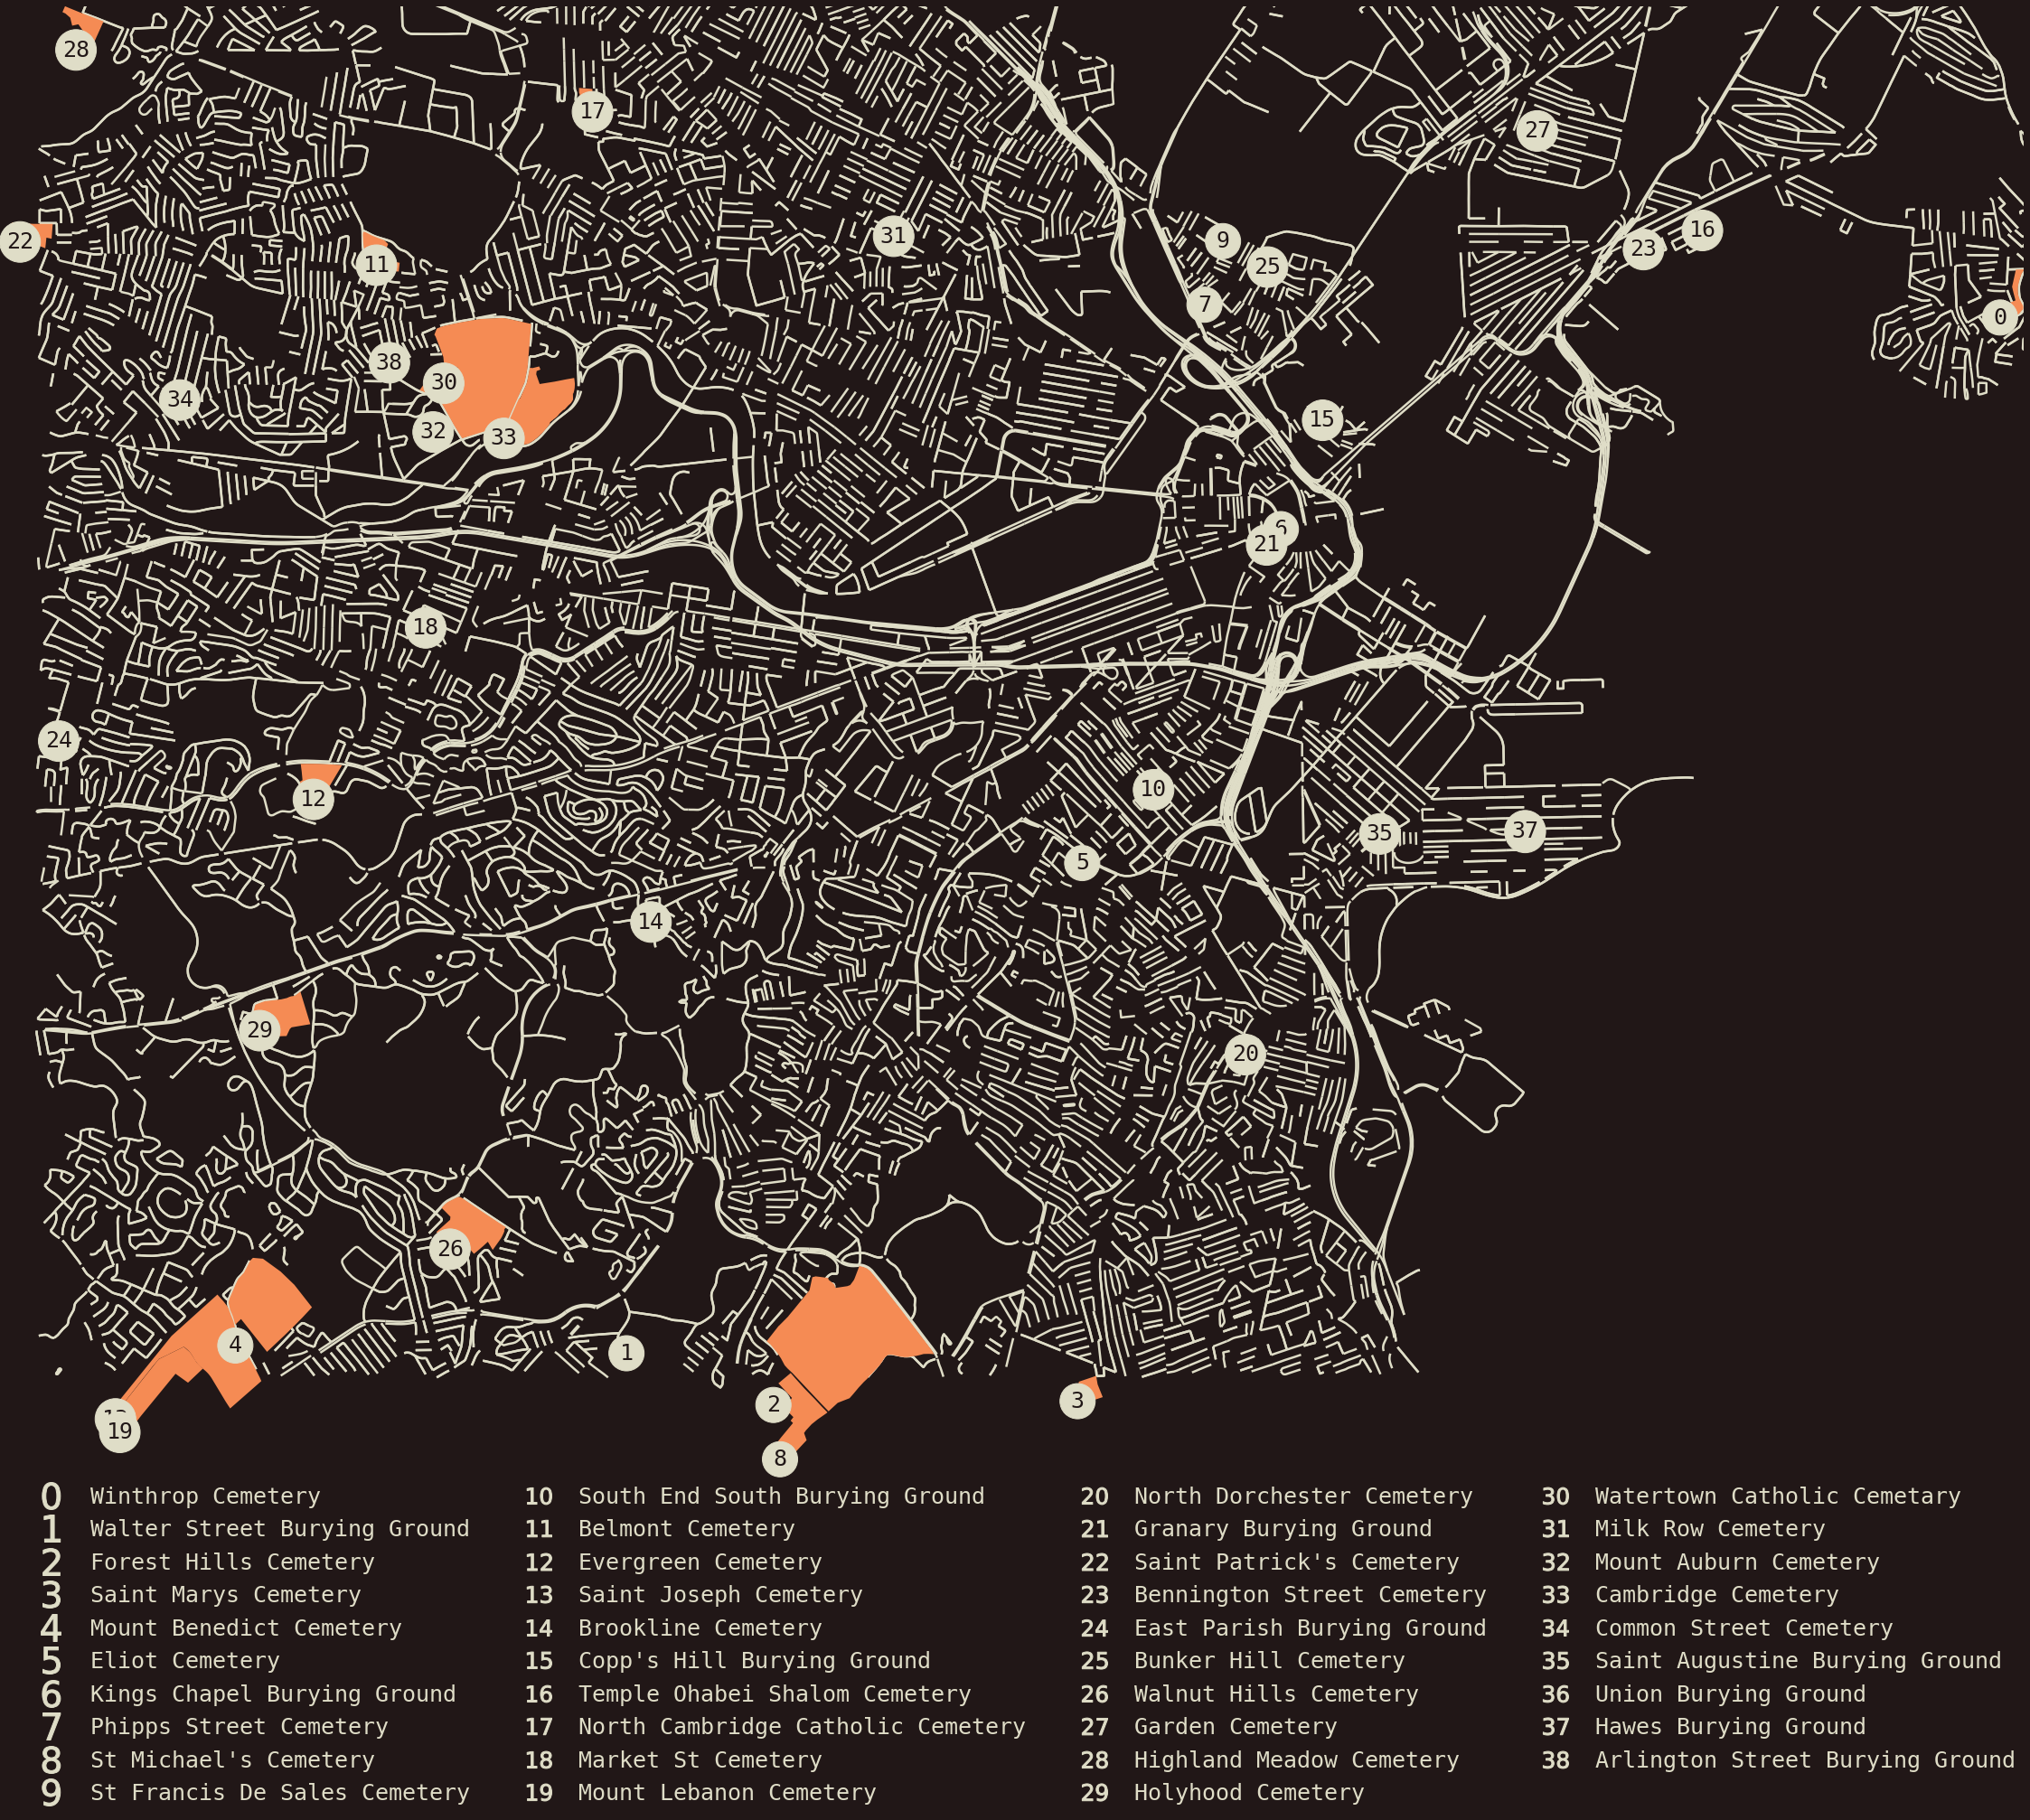

In [184]:
img = plot_map(bounding_box_BOS)

/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Placing label 0 for Old Burial Ground at -70.96555, 42.461276
Placing label 1 for Pine Grove Cemetery at -70.9677798, 42.4713778
Placing label 2 for Old East Burying Ground at -70.9410958, 42.467676
Placing label 3 for Winthrop Cemetery at -70.9830733, 42.3748496
Placing label 4 for St. Mary's Cemetery at -70.9741605, 42.4880885
Placing label 5 for Forest Hills Cemetery at -71.1146014, 42.2886428
Placing label 6 for Saint Marys Cemetery at -71.0819871, 42.2889412
Placing label 7 for Mount Hope Cemetery at -71.1135103, 42.2783289
Placing label 8 for Grove Hill Cemetery at -71.2223949, 42.3744997
Placing label 9 for Forestdale Cemetery at -71.0670958, 42.4359931
Placing label 10 for Mount Benedict Cemetery at -71.1723007, 42.2933556
Placing label 11 for Salem St. Cemetery at -71.0625834, 42.4269365
Placing label 12 for Oaklawn Cemetery at -71.1159344, 42.2717575
Placing label 13 for Glenwood Cemetery at -71.4489707, 42.4223621
Placing label 14 for Woodlawn Cemetery at -71.4281361, 42.478

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


Placing label 63 for Woodbrook Cemetery at -71.1498247, 42.4850724
Placing label 64 for Mount Wollaston Cemetery at -71.002436, 42.2556617
Placing label 65 for Oak Grove Cemetery at -71.1419468, 42.4274205
Placing label 66 for Saint Patrick's Cemetery at -71.1961123, 42.3808391
Placing label 67 for Codman Burial Ground at -71.0755483, 42.2888578
Placing label 68 for Village Cemetery at -71.1802, 42.2461702
Placing label 69 for Bennington Street Cemetery at -71.0220282, 42.3802371
Placing label 70 for Glenwood Cemetery at -71.3232356, 42.2613828
Placing label 71 for East Parish Burying Ground at -71.1919599, 42.3412688
Placing label 72 for Riverside Cemetery at -71.0089739, 42.459293
Placing label 73 for Hancock Cemetery at -71.0044734, 42.2499011
Placing label 74 for Walnut Hills Cemetery at -71.150014, 42.3009886
Placing label 75 for Garden Cemetery at -71.0334191, 42.3896356
Placing label 76 for Highland Meadow Cemetery at -71.1901139, 42.3960584
Placing label 77 for Saint Bernards P

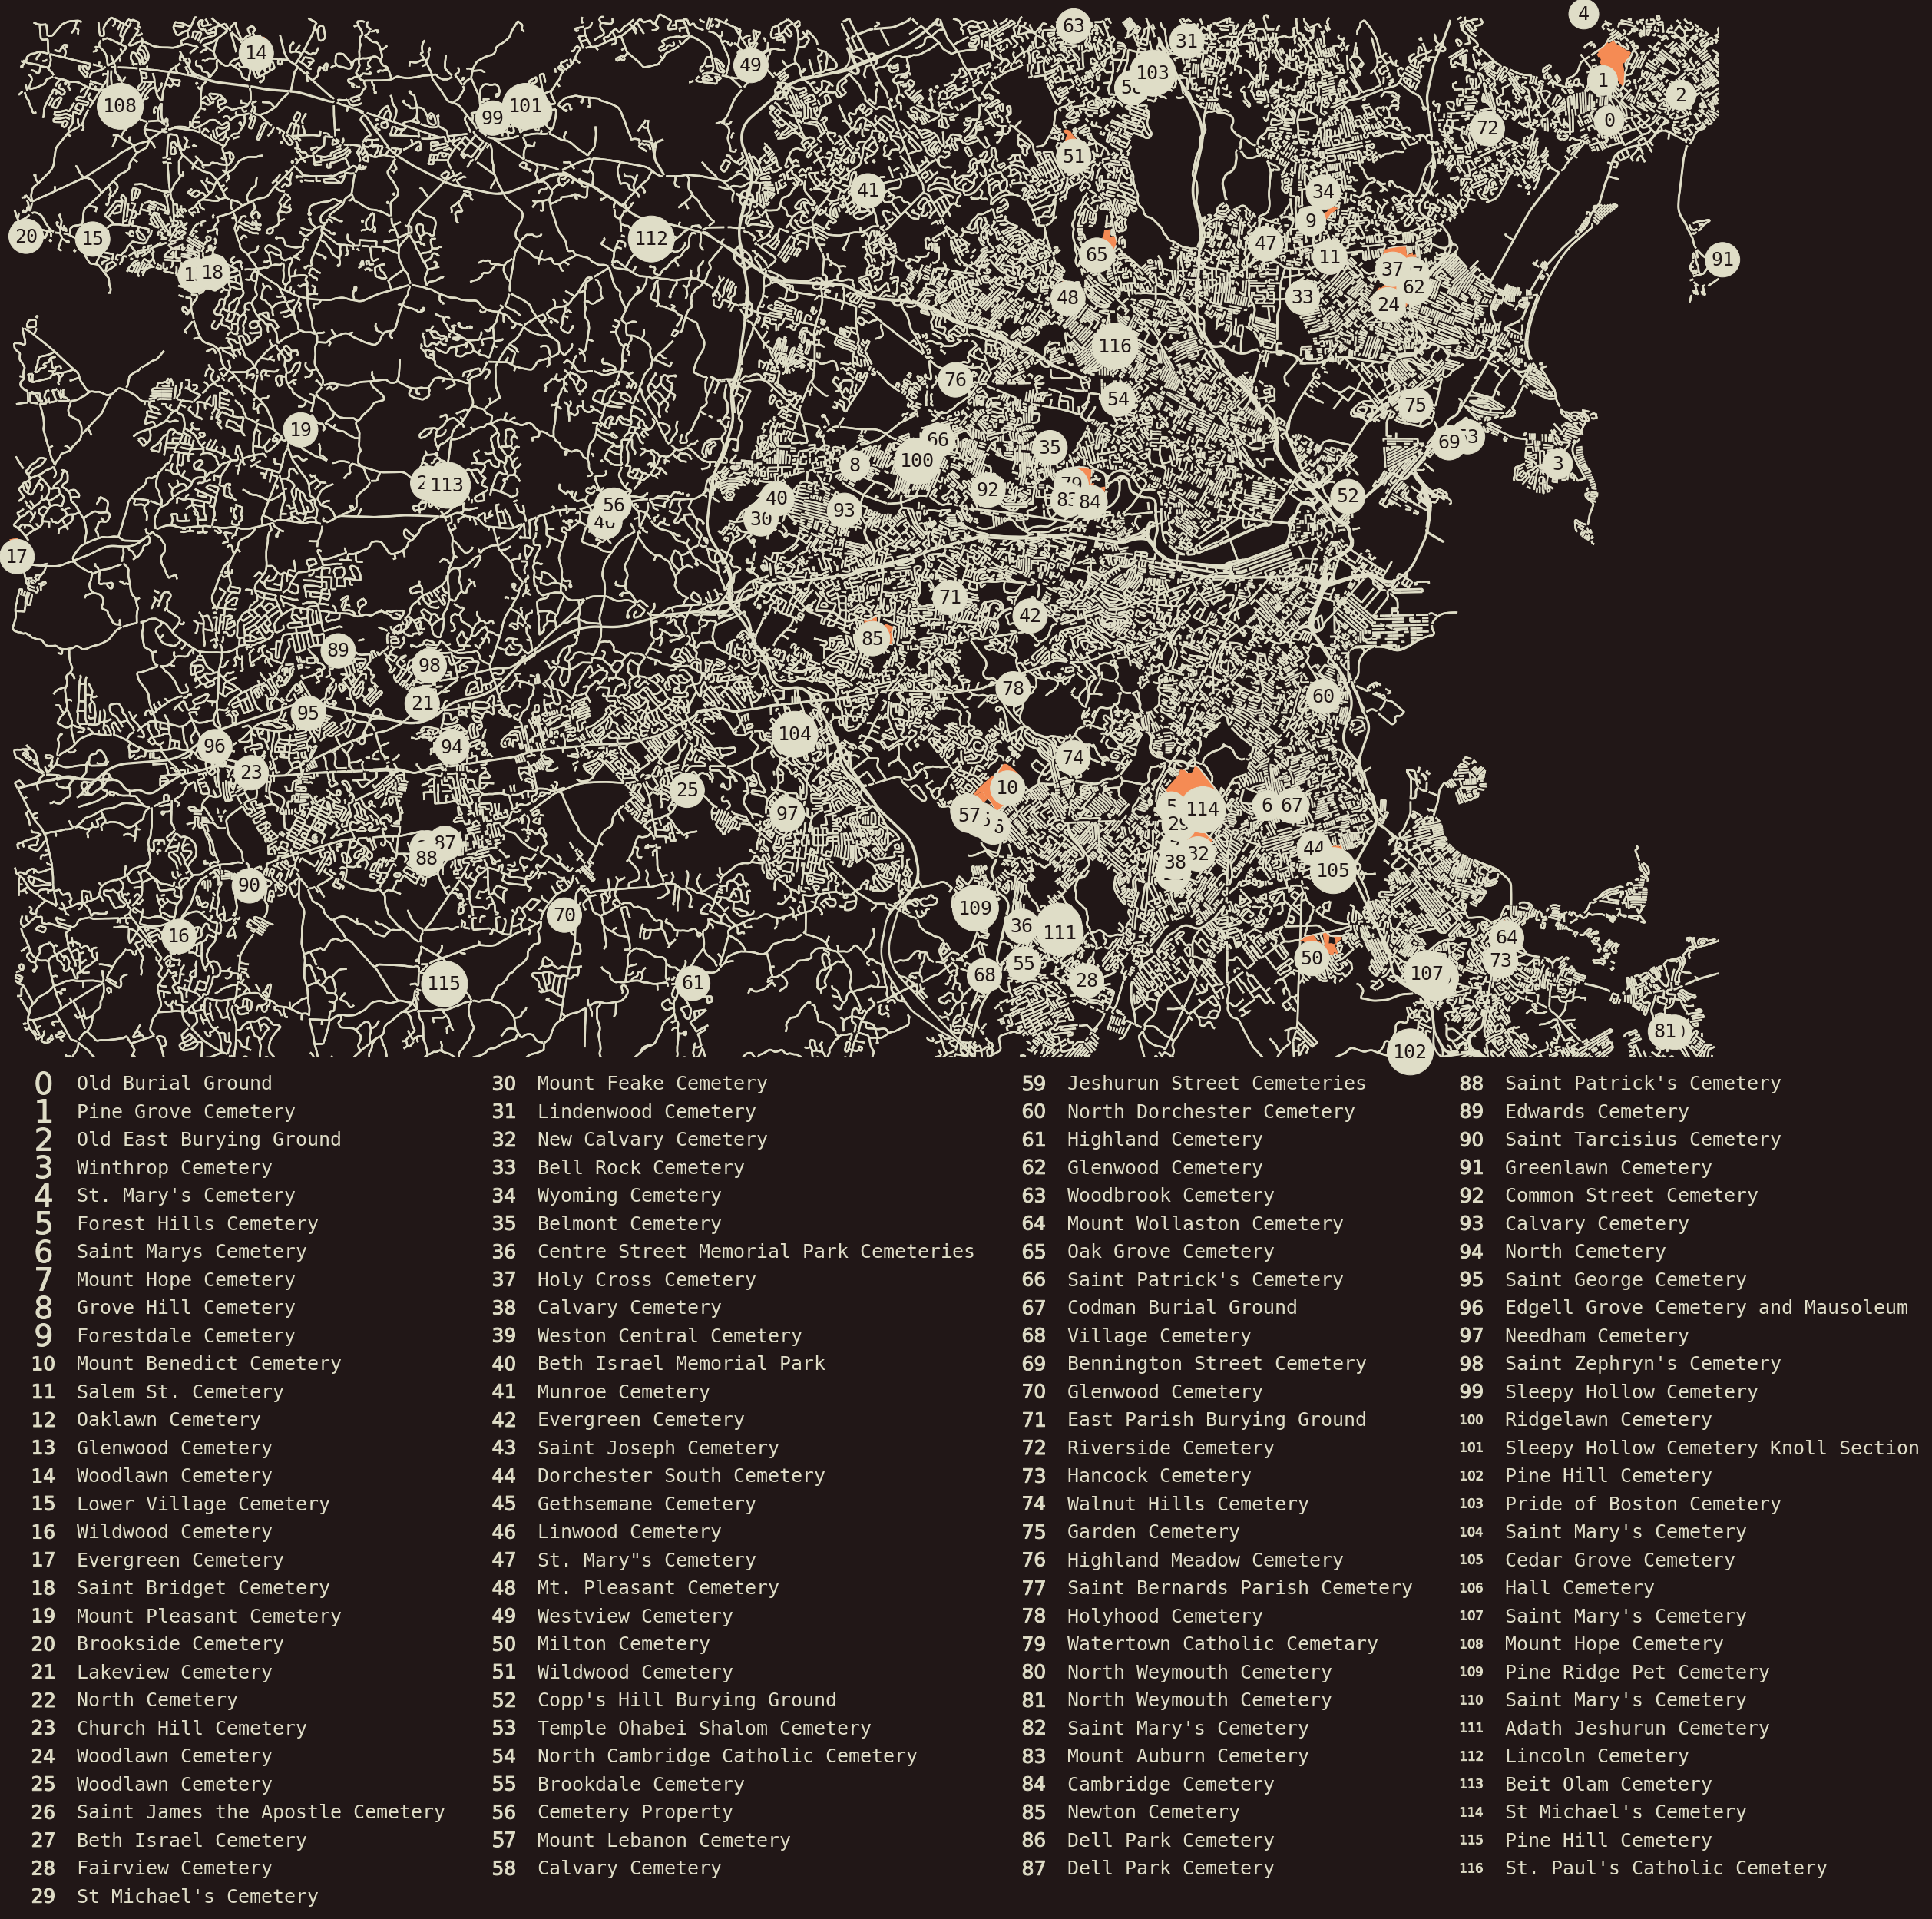

In [182]:
img = plot_map(bounding_box_BOS_BIG)

In [34]:
img_with_border = add_border('bbox_cemetery.png', 'bbox_cemetery_border.png', fill=BACKGROUND, bottom=1600)
#img_with_border = add_border('bbox_cemetery.png', 'bbox_cemetery_border_color.png', fill="#a34a28", bottom=800)

In [118]:
cemeteries.columns

Index(['unique_id', 'osmid', 'element_type', 'access', 'barrier', 'geometry',
       'source', 'amenity', 'ele', 'gnis:county_id', 'gnis:created',
       'gnis:feature_id', 'gnis:state_id', 'historic', 'image', 'name',
       'place_name', 'tomb', 'height', 'website', 'wikidata', 'wikipedia',
       'nodes', 'area', 'historical', 'landuse', 'massgis:ARTICLE97',
       'massgis:ASSESS_ACR', 'massgis:ATT_DATE', 'massgis:DCAM_ID',
       'massgis:DEED_ACRES', 'massgis:EOEAINVOLV', 'massgis:FEESYM',
       'massgis:FEE_OWNER', 'massgis:FY_FUNDING', 'massgis:LEV_PROT',
       'massgis:OS_DEED_BO', 'massgis:OS_DEED_PA', 'massgis:OS_ID',
       'massgis:OWNER_ABRV', 'massgis:OWNER_TYPE', 'massgis:POLY_ID',
       'massgis:PRIM_PURP', 'massgis:PUB_ACCESS', 'massgis:SITE_NAME',
       'massgis:TOWN_ID', 'owner', 'ownership', 'protected',
       'massgis:ASSESS_BLK', 'massgis:ASSESS_LOT', 'massgis:ASSESS_MAP',
       'massgis:BASE_MAP', 'massgis:MANAGER', 'massgis:MANAGR_ABR',
       'massgis:MA